In [98]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Dense, LSTM, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import pandas as pd
import numpy as np

import sys
import os

from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load features


In [99]:
emotions = ['fear', 'contempt', 'happiness', 'anger',
            'sadness', 'neutral', 'surprise']
emotions_number = len(emotions)
print(emotions, emotions_number)

['fear', 'contempt', 'happiness', 'anger', 'sadness', 'neutral', 'surprise'] 7


In [100]:
# # features-train-all-v4 - melspectrogram only 128-65
# features_train_df = pd.read_csv('./features/features-train-all-mfcc-v2.csv')
# features_test_df = pd.read_csv('./features/features-test-all-mfcc-v2.csv')
# features_val_df = pd.read_csv('./features/features-val-all-mfcc-v2.csv')
# features_train_df.head()

In [101]:
# emofilm_info_df = pd.read_csv('D:/Documents/emofilm/data/complete_info.csv')
emofilm_uk_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/emofilm_uk_df.csv')
emofilm_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/emofilm_df.csv')
ravdess_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/ravdess_df.csv')
savee_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/savee_df.csv')
tess_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/tess_df.csv')
cremad_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/cremad_df.csv')

In [102]:
data_df = pd.concat([ravdess_df, savee_df, tess_df, cremad_df, emofilm_df],
                    axis=0, ignore_index=True)
# data_df = pd.concat([emofilm_uk_df, emofilm_df, ravdess_df, savee_df, tess_df, cremad_df],
#                     axis=0, ignore_index=True)
data_df_no_uk = pd.concat([emofilm_df,
                           #    ravdess_df, savee_df, tess_df, cremad_df
                           ],
                          axis=0, ignore_index=True)
data_df_no_uk

,emotion,path
0,fear,D:/Programming/nn/emotion_classification/datas...
1,fear,D:/Programming/nn/emotion_classification/datas...
2,fear,D:/Programming/nn/emotion_classification/datas...
3,fear,D:/Programming/nn/emotion_classification/datas...
4,fear,D:/Programming/nn/emotion_classification/datas...
...,...,...
1110,sadness,D:/Programming/nn/emotion_classification/datas...
1111,sadness,D:/Programming/nn/emotion_classification/datas...
1112,sadness,D:/Programming/nn/emotion_classification/datas...
1113,sadness,D:/Programming/nn/emotion_classification/datas...


In [103]:
def add_folds(dataframe, test_k, val_k):
    df = dataframe.sample(frac=1).reset_index(drop=True)  # shuffle

    test_len = int(len(df) * test_k)
    val_len = int(len(df) * val_k)
    train_len = int(len(df) - test_len - val_len)

    folds = []
    for i in range(test_len):
        folds.append('test')

    for i in range(val_len):
        folds.append('val')

    for i in range(train_len):
        folds.append('train')

    df.insert(0, 'fold', folds, True)

    return df

In [104]:
data_df_no_uk = add_folds(data_df_no_uk, 0.2, 0.2)
data_df = add_folds(data_df, 0.2, 0.2)

In [105]:
data_df_no_uk.head(2)

,fold,emotion,path
0,test,happiness,D:/Programming/nn/emotion_classification/datas...
1,test,sadness,D:/Programming/nn/emotion_classification/datas...


In [106]:
0.975 * 16000

15600.0

In [107]:
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    # file_contents = tf.io.read_file(filename)
    # wav, sample_rate = tf.audio.decode_wav(
    #     file_contents,
    #     desired_channels=1)
    # wav = tf.squeeze(wav, axis=-1)
    # sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    # Downsample 44.1kHz to 16kHz
    wav, s = librosa.load(filename, sr=16000, duration=1)

    # The model accepts a 1-D float32 Tensor or NumPy array of length 15600
    # containing a 0.975-second waveform represented as mono 16 kHz samples in the range [-1.0, +1.0].
    fixed_length = int(0.975 * 16000)
    wav = librosa.util.fix_length(wav, size=fixed_length)
    return wav

In [108]:
# X = np.zeros((1, int(0.975 * 16000)))
# y = []
# for i, row in data_df_no_uk.iterrows():
#     audio = load_wav_16k_mono(row['path'])
#     X = np.vstack((X, audio))
#     y.append(row['emotion'])
# y = np.array(y)
# X = np.delete(X, 0, 0)

In [109]:
# audio_data = {'emotion': [], 'data': []}
# for i, row in data_df.iterrows():
#     audio = load_wav_16k_mono(row['path'])
#     audio_data['emotion'].append(row['emotion'])
#     audio_data['data'].append(audio)

# audio_data_df = pd.DataFrame(audio_data)
# del audio_data
# audio_data_df.head()

# X = audio_data_df['data'].to_numpy()
# # X = audio_data_df['data']
# y = audio_data_df[['emotion']]

In [110]:
# encoder = OneHotEncoder()
# # y_enc = encoder.fit_transform(y).toarray()
# y_enc = encoder.fit_transform(y.reshape(-1, 1)).toarray()

In [111]:
# x_train, x_test, y_train, y_test = train_test_split(
#     X, y_enc, test_size=0.2, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(
#     x_train, y_train, test_size=0.2, random_state=42)

# y_test_dec = encoder.inverse_transform(y_test)

# # x_train = tf.convert_to_tensor(x_train, tf.float32)
# # x_test = tf.convert_to_tensor(x_test, tf.float32)
# # x_val = tf.convert_to_tensor(x_val, tf.float32)

In [112]:
# x_train = x_train.reshape(-1)
# x_val = x_val.reshape(-1)

In [113]:
# print(
#     f'x_train: {x_train.shape}\tx_val: {x_val.shape}\tx_test: {x_test.shape}')

In [114]:
# tf.squeeze(x_train[0])

## Transfer model


load model

In [115]:
import tensorflow_hub as hub
import tensorflow_io as tfio

In [34]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load('D:/yamnet/')

In [35]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

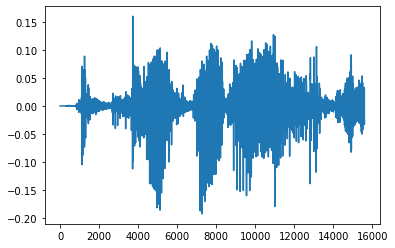

In [36]:
testing_wav_data = load_wav_16k_mono(
    "D:/Programming/nn/emotion_classification/datasets/emofilm/wav_corpus/f_ans001aen.wav")

_ = plt.plot(testing_wav_data)

# Play the audio file.
Audio(testing_wav_data, rate=16000)

In [37]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names = list(pd.read_csv(class_map_path)['display_name'])

In [40]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Speech
The embeddings shape: (1, 1024)


In [39]:
# filenames = data_df['path']
# targets = data_df['emotion']

# main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))
# main_ds.element_spec

In [37]:
# X = np.zeros((1, 1024))
# y = []

# for i, row in data_df.iterrows():
#     audio = load_wav_16k_mono(row['path'])
#     X = np.vstack((X, audio))
#     y.append(row['emotion'])
# y = np.array(y)
# X = np.delete(X, 0, 0)

In [41]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data):
    ''' run YAMNet to extract embedding from the wav data '''
    _, embeddings, _ = yamnet_model(wav_data)
    # num_embeddings = tf.shape(embeddings)[0]
    return embeddings

In [52]:
def create_embeddings(dataframe):
    embeddings = {'emotion': [], 'embedding': [], 'path': [], 'fold': []}
    X = np.zeros((1, 1024))
    y = []
    for i, row in dataframe.iterrows():
        wav = load_wav_16k_mono(row['path'])
        embedding = extract_embedding(wav)
        for i in range(tf.shape(embedding)[0]):
            X = np.vstack((X, embedding[i]))
            y.append(row['emotion'])

            embeddings['embedding'].append(embedding[i])
            embeddings['emotion'].append(row['emotion'])
            embeddings['path'].append(row['path'])
            embeddings['fold'].append(row['fold'])
    return pd.DataFrame(embeddings), X, y


# extract embedding
main_ds, X, y = create_embeddings(data_df)
main_ds

,emotion,embedding,path,fold
0,fear,"(tf.Tensor(0.13457298, shape=(), dtype=float32...",D:/Programming/nn/emotion_classification/datas...,test
1,sadness,"(tf.Tensor(0.16979593, shape=(), dtype=float32...",D:/Programming/nn/emotion_classification/datas...,test
2,surprise,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",D:/Programming/nn/emotion_classification/datas...,test
3,contempt,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",D:/Programming/nn/emotion_classification/datas...,test
4,happiness,"(tf.Tensor(0.019596098, shape=(), dtype=float3...",D:/Programming/nn/emotion_classification/datas...,test
...,...,...,...,...
13272,fear,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",D:/Programming/nn/emotion_classification/datas...,train
13273,fear,"(tf.Tensor(0.088616304, shape=(), dtype=float3...",D:/Programming/nn/emotion_classification/datas...,train
13274,happiness,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",D:/Programming/nn/emotion_classification/datas...,train
13275,anger,"(tf.Tensor(0.07434075, shape=(), dtype=float32...",D:/Programming/nn/emotion_classification/datas...,train


In [53]:
train_ds = main_ds.loc[main_ds['fold'] == 'train']
test_ds = main_ds.loc[main_ds['fold'] == 'test']
val_ds = main_ds.loc[main_ds['fold'] == 'val']

In [54]:
x_train = train_ds['embedding']
y_train = train_ds[['emotion']]

x_test = test_ds['embedding']
y_test = test_ds[['emotion']]

x_val = val_ds['embedding']
y_val = val_ds[['emotion']]

In [55]:
x_train = np.array([xi.numpy() for xi in x_train.to_numpy()])
x_test = np.array([xi.numpy() for xi in x_test.to_numpy()])
x_val = np.array([xi.numpy() for xi in x_val.to_numpy()])

In [56]:
main_ds.emotion.unique().tolist()

['fear',
 'sadness',
 'surprise',
 'contempt',
 'happiness',
 'calm',
 'anger',
 'neutral']

In [57]:
encoder = OneHotEncoder()
# y_enc = encoder.fit_transform(y).toarray()
y_train = encoder.fit_transform(y_train).toarray()
y_val = encoder.fit_transform(y_val).toarray()

In [41]:
# for i in X[:5]:
#     print(i)

[0. 0. 0. ... 0. 0. 0.]
[0.04202275 0.39931166 0.21554422 ... 0.21378797 0.         0.        ]
[0.04880255 0.1412756  0.02507512 ... 0.19882715 0.         0.        ]
[0.02852636 0.53949267 0.00599041 ... 0.         0.         0.        ]
[0.         0.5783934  0.25392845 ... 0.         0.         0.        ]


In [109]:
# # X = main_ds['embedding']
# # y = main_ds[['emotion']]

# y = np.array(y)
# X = np.delete(X, 0, 0)

In [110]:
# encoder = OneHotEncoder()
# # y_enc = encoder.fit_transform(y).toarray()
# y_enc = encoder.fit_transform(y.reshape(-1, 1)).toarray()

In [111]:
# x_train, x_test, y_train, y_test = train_test_split(
#     X, y_enc, test_size=0.2, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(
#     x_train, y_train, test_size=0.2, random_state=42)

# y_test_dec = encoder.inverse_transform(y_test)

In [114]:
# print(
#     f'x_train: {x_train.shape}\tx_val: {x_val.shape}\tx_test: {x_test.shape}')

x_train: (7783, 1024)	x_val: (1946, 1024)	x_test: (2433, 1024)


In [72]:
train_size=len(x_train)
batch_size=128
epochs=50

initial_learning_rate = 0.001
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.96
)

In [95]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024, 1), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Conv1D(32, 3, 1, padding='same', activation='relu'),
    tf.keras.layers.AveragePooling1D(),

    tf.keras.layers.Conv1D(32, 3, 1, padding='same', activation='relu'),
    tf.keras.layers.AveragePooling1D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Reshape((32, 256)),
    tf.keras.layers.LSTM(64, input_shape=(32, 256)),
    # tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1])
], name='my_model')

my_model.summary()


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
my_model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy', metrics=['accuracy'])

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 1024, 32)          128       
                                                                 
 average_pooling1d_24 (Avera  (None, 512, 32)          0         
 gePooling1D)                                                    
                                                                 
 conv1d_25 (Conv1D)          (None, 512, 32)           3104      
                                                                 
 average_pooling1d_25 (Avera  (None, 256, 32)          0         
 gePooling1D)                                                    
                                                                 
 flatten_12 (Flatten)        (None, 8192)              0         
                                                                 
 reshape_12 (Reshape)        (None, 32, 256)           0  

In [96]:
rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.4,
                                            verbose=0, patience=5, min_lr=0.0000001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = my_model.fit(x=x_train,
                       y=y_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(x_val, y_val),
                       callbacks=[early_stopping])

Epoch 1/50
63/63 [==============================] - 4s 28ms/step - loss: 4.1700 - accuracy: 0.1613 - val_loss: 13.3522 - val_accuracy: 0.1642
Epoch 2/50
63/63 [==============================] - 1s 20ms/step - loss: 11.0969 - accuracy: 0.1757 - val_loss: 10.3742 - val_accuracy: 0.1687
Epoch 3/50
63/63 [==============================] - 1s 20ms/step - loss: 6.6136 - accuracy: 0.1646 - val_loss: 5.7491 - val_accuracy: 0.1627
Epoch 4/50
63/63 [==============================] - 1s 20ms/step - loss: 5.6768 - accuracy: 0.1642 - val_loss: 5.7491 - val_accuracy: 0.1627
Epoch 5/50
63/63 [==============================] - 1s 20ms/step - loss: 5.6768 - accuracy: 0.1642 - val_loss: 5.7491 - val_accuracy: 0.1627
Epoch 6/50
63/63 [==============================] - 1s 20ms/step - loss: 5.6768 - accuracy: 0.1642 - val_loss: 5.7491 - val_accuracy: 0.1627
Epoch 7/50
63/63 [==============================] - 1s 20ms/step - loss: 5.6768 - accuracy: 0.1642 - val_loss: 5.7491 - val_accuracy: 0.1627


In [97]:
y_pred = my_model.predict(x_test)

y_pred_decoded = encoder.inverse_transform(y_pred)

83/83 [==============================] - 1s 5ms/step


In [89]:
def print_report_v2(history):
    epochs = history.epoch
    fig, ax = plt.subplots(1, 2)

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20, 6)
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")

    plt.show()


def print_confusion_matrix(test, pred, size=(12, 10)):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=size)
    cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
        i for i in encoder.categories_])
    sns.heatmap(cm, linecolor='white', cmap='Blues',
                linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

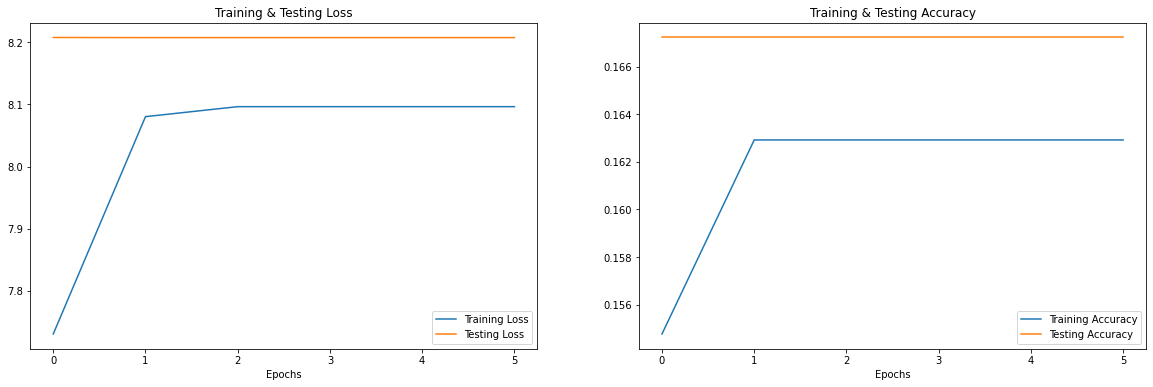

In [90]:
print_report_v2(history)

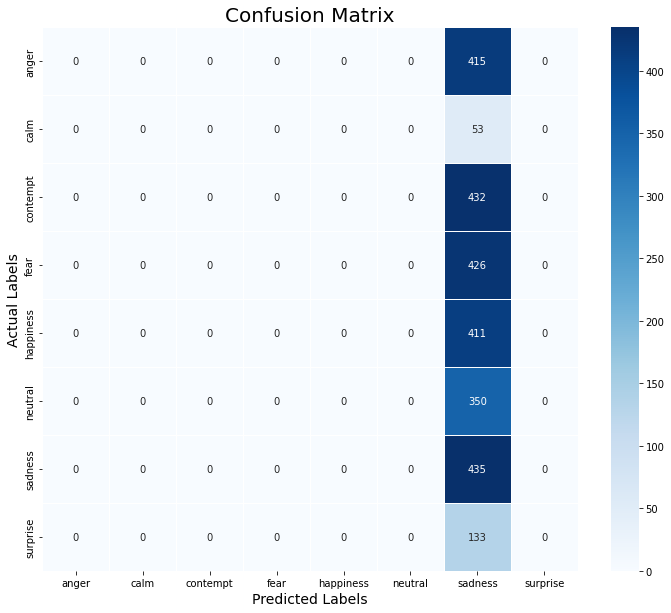

In [91]:
print_confusion_matrix(y_test, y_pred_decoded)

In [92]:
print(classification_report(y_test, y_pred_decoded))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       415
        calm       0.00      0.00      0.00        53
    contempt       0.00      0.00      0.00       432
        fear       0.00      0.00      0.00       426
   happiness       0.00      0.00      0.00       411
     neutral       0.00      0.00      0.00       350
     sadness       0.16      1.00      0.28       435
    surprise       0.00      0.00      0.00       133

    accuracy                           0.16      2655
   macro avg       0.02      0.12      0.04      2655
weighted avg       0.03      0.16      0.05      2655



In [65]:
# Add an extra dimension at the end
x_train_reshaped = np.expand_dims(x_train, axis=-1)
x_val_reshaped = np.expand_dims(x_val, axis=-1)

In [66]:
scores, embeddings, _ = yamnet_model(x_train[0])

class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Vehicle
The embeddings shape: (1, 1024)


## Test another yamnet:

In [ ]:
yamnet_model_handle = "https://tfhub.dev/google/lite-model/yamnet/classification/tflite/1"
yamnet_model = hub.KerasLayer(yamnet_model_handle, trainable=False)

# Define your custom model for transfer learning
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15600)),  # Input shape for audio data
    yamnet_model,  # YamNet model as a feature extractor
    # Add your custom layers for classification
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # Output layer for classification
    tf.keras.layers.Dense(emotions_number, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [126]:
input_segment = tf.keras.layers.Input(
    shape=(15600), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)

# saved_model_path = './dogs_and_cats_yamnet'
# serving_model.save(saved_model_path, include_optimizer=False)

ValueError: Exception encountered when calling layer "yamnet" (type KerasLayer).

in user code:

    File "C:\Users\nicko\AppData\Roaming\Python\Python310\site-packages\tensorflow_hub\keras_layer.py", line 242, in call  *
        result = f()

    ValueError: Python inputs incompatible with input_signature:
      inputs: (
        Tensor("Placeholder:0", shape=(None, 15600), dtype=float32))
      input_signature: (
        TensorSpec(shape=(None,), dtype=tf.float32, name=None)).


Call arguments received by layer "yamnet" (type KerasLayer):
  • inputs=tf.Tensor(shape=(None, 15600), dtype=float32)
  • training=None

In [108]:
serving_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      optimizer="adam",
                      metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [118]:
x_train.shape

(11122800,)

In [117]:
history = serving_model.fit(x=x_train,
                            y=y_train,
                            epochs=5,
                            validation_data=(x_val, y_val),
                            callbacks=callback)

ValueError: Data cardinality is ambiguous:
  x sizes: 11122800
  y sizes: 713
Make sure all arrays contain the same number of samples.